In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from lightgbm import LGBMClassifier
import pickle
import joblib

In [2]:
df = pd.read_parquet('../data/all_data_preprocessed/all_merged.parquet')

In [3]:
X = df.drop(columns=[
    'event_all_region', 'alarms_in_regions', 'event_1h_ago',
    'event_2h_ago'])
y = df['event_all_region']
X.rename(columns={"event_1h_ago": "status"}, inplace=True)

In [4]:
tscv = TimeSeriesSplit(n_splits=5)
splits = list(tscv.split(X))
train_idx, test_idx = splits[-1]
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

In [5]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [6]:
scaler = joblib.load('../src/our_models/scaler_v1.pkl')
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:
weight = sum(y_train==0)/sum(y_train==1)
weight

2.78725174626114

In [8]:
lgb_model = LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',
    device='gpu',
    scale_pos_weight=weight,
    random_state=42,
    n_jobs=1
)


In [9]:
param_dist = {
    'learning_rate': [0.03, 0.05, 0.07],
    'num_leaves': [20, 31, 50],
    'n_estimators': [100, 150, 200]
}

In [10]:
random_search = RandomizedSearchCV(
    lgb_model,
    param_distributions=param_dist,
    n_iter=10,
    scoring='roc_auc',
    cv=tscv,
    verbose=2,
    random_state=42,
    n_jobs=8, # change
    refit=False
)

In [11]:
random_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=LGBMClassifier(device='gpu', n_jobs=1,
                                            objective='binary', random_state=42,
                                            scale_pos_weight=2.78725174626114),
                   n_jobs=8,
                   param_distributions={'learning_rate': [0.03, 0.05, 0.07],
                                        'n_estimators': [100, 150, 200],
                                        'num_leaves': [20, 31, 50]},
                   random_state=42, refit=False, scoring='roc_auc', verbose=2)

In [16]:
results_df = pd.DataFrame(random_search.cv_results_)
best_row = results_df.loc[results_df['rank_test_score'] == 1]
best_params = best_row['params'].values[0]

print(best_params)

{'num_leaves': 50, 'n_estimators': 200, 'learning_rate': 0.05}


In [18]:
best_lgb = LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',
    scale_pos_weight=weight,
    n_jobs=-1,
    random_state=42,
    **best_params
)


In [19]:
best_lgb.fit(X_train_scaled, y_train)

[LightGBM] [Info] Number of positive: 137007, number of negative: 381873
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.532132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 256880
[LightGBM] [Info] Number of data points in the train set: 518880, number of used features: 1039
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.264044 -> initscore=-1.025056
[LightGBM] [Info] Start training from score -1.025056


LGBMClassifier(learning_rate=0.05, n_estimators=200, n_jobs=-1, num_leaves=50,
               objective='binary', random_state=42,
               scale_pos_weight=2.78725174626114)

In [20]:
y_pred = best_lgb.predict(X_test_scaled)
accuracy_score(y_test, y_pred)

D:\NaUKMA\DS\H2_python_structure_and_data\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


0.8662985661424607

In [21]:
confusion_matrix(y_test, y_pred)

array([[75451, 10303],
       [ 3572, 14450]])

In [22]:
f1_score(y_test, y_pred)

0.6756282875511397

In [23]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.95      0.88      0.92     85754
         1.0       0.58      0.80      0.68     18022

    accuracy                           0.87    103776
   macro avg       0.77      0.84      0.80    103776
weighted avg       0.89      0.87      0.87    103776



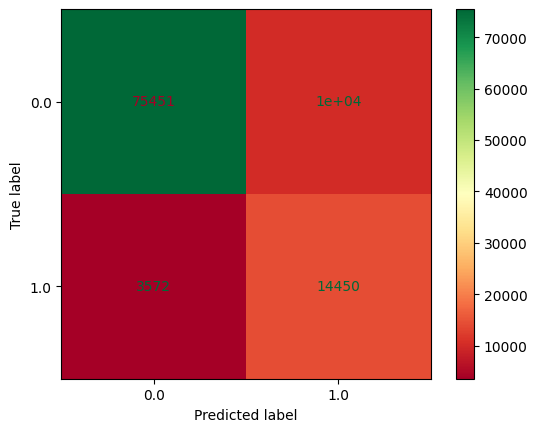

In [24]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='RdYlGn')

In [25]:
with open('our_models/3__LightGBM__v1.pkl', 'wb') as f:
    pickle.dump(best_lgb, f)